In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy, re

# import metrics to show accuracy, recall, precision and ...
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, balanced_accuracy_score


from sklearn.feature_extraction.text import TfidfVectorizer

# Import libraries and packages
import pandas as pd
import numpy as np
import re
from gensim import corpora, models, similarities, matutils
import string
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet, sentiwordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import time
import emoji

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon') # vader sentiment
nltk.download('sentiwordnet') # sentiwordnet sentiment
nltk.download('punkt')

stemmer = PorterStemmer()
sentiment_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /Users/miao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/miao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/miao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/miao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/miao/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/miao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [394]:
df = pd.read_csv("../Airline-Sentiment.csv", encoding='utf8')

In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          14640 non-null  int64  
 1   sentiment   14640 non-null  int64  
 2   confidence  14640 non-null  float64
 3   text        14640 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 457.6+ KB


In [396]:
df = df.fillna("")
df['confidence'] = pd.to_numeric(df['confidence'])
df['sentiment'] = pd.to_numeric(df['sentiment'])
df = df.loc[df['confidence'] >= 0.6]
df = df.reset_index()
df = df.drop(columns=['index'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14402 entries, 0 to 14401
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          14402 non-null  int64  
 1   sentiment   14402 non-null  int64  
 2   confidence  14402 non-null  float64
 3   text        14402 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 450.2+ KB


In [397]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [398]:
def clean_text(text):
    # lower the text
    text = text.lower()
    
    # remove mentions @
    text = re.sub(r'(@|#)[^ ]*([ ]|$)', '', text)
    text = re.sub(r'https?:\/\/[^ ]*([ ]|$)', '', text)
    text = re.sub(r'&[\w+]+;', ' ', text)
    text = re.sub(r'(:|;)-?\)', '', text)
    text = text.replace("'re", " are")\
        .replace("he's", "he is")\
        .replace("He's", "He is")\
        .replace("'ll", " will")\
        .replace("'ve", " have")\
        .replace("won't", "will not")\
        .replace("n't", " not")\
        .replace("'d", " would")
    text = re.sub(r'(\r\n)+', '\r\n', text)
    text = re.sub(r'(\r)+', '\r', text)
    text = re.sub('(\n)+', '\n', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = re.sub(r'[ ]+', ' ', text)
    text = text.replace('\r\n', '')\
        .replace('\r', '')\
        .replace('\n', '')
    text = text.strip()
    
    # remove hyperlink
    text = re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    # converting emoji
    text = emoji.demojize(text)
    text = re.sub(r':[a-z_&]+:', '', text)

    # replace all types of negations: no, n't, never
    text = text.replace("he's", "he is").replace("I'm", "I am").replace("'re", " are").replace("ain't", "are not")\
    .replace("'ve", " have").replace("'ll", " will").replace("won't", "will not").replace("can't", "can not")\
    .replace("n't", " not").replace("'d", " would")
    
    # remove all symbols
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)

    # tokenize the text with removal of non-words,  punctuation, short (< 3 symbols) and long (> 25 symbols) tokens
    text = [word.strip() for word in text.split() if len(word.strip()) >= 3 and len(word.strip()) <= 25]

    # filtering English stopwords, and remove digits
    stop = stopwords.words('english')
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if word not in stop]

    # Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database (retaining nouns and adjectives)
    pos_tags = pos_tag(text)
    pos_tags = list(filter(lambda x: get_wordnet_pos(x[1]) is not None, pos_tags))
    text = [w for w, t in pos_tags if get_wordnet_pos(t) == wordnet.NOUN or get_wordnet_pos(t) == wordnet.ADJ]

    # stemming (reducing inflected words to their word stems using Porter stemmer)
    text = [stemmer.stem(word) for word in text]

    # lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)
    text = [WordNetLemmatizer().lemmatize(w, get_wordnet_pos(t)) for w, t in pos_tags]
 
    # join the token
    text = ' '.join(text)
    return(text)

In [399]:
df["review_clean"] = df["text"].apply(lambda x: clean_text(x))

In [400]:
# training and validation set
labels = []
reviews = []

num_of_train_and_validation = 0
num_of_neutral = 0
num_of_pos = 0
num_of_neg = 0
for index in range(0, df.shape[0]):
    if df['sentiment'][index] == 0:
        num_of_neutral += 1
    elif df['sentiment'][index] == 1:
        num_of_pos += 1
    elif df['sentiment'][index] == -1:
        num_of_neg += 1
        # continue
    labels.append(df['sentiment'][index])
    reviews.append(df['review_clean'][index])
    num_of_train_and_validation += 1
    
print("[%s] neutral reviews." % str(num_of_neutral))
print("[%s] postive reviews." % str(num_of_pos))
print("[%s] negtive reviews." % str(num_of_neg))
print("[%s] train and validation rows." % str(num_of_train_and_validation))

reviews_tokens = [r for r in reviews]

[2997] neutral reviews.
[2292] postive reviews.
[9113] negtive reviews.
[14402] train and validation rows.


In [401]:
# option 1: split data into training set and test set
x_train, x_test, y_train, y_test = train_test_split(reviews_tokens, labels, test_size=0.1, random_state=1)

In [402]:
x_test.__len__()

1441

In [403]:
x_train.__len__()

12961

In [404]:
# find max features
_tf = TfidfVectorizer()
_xt = _tf.fit_transform(x_train)
_xtest = _tf.fit_transform(x_test)
_tf.vocabulary_.__len__()

2575

Model [linear svc] at [300] features ->



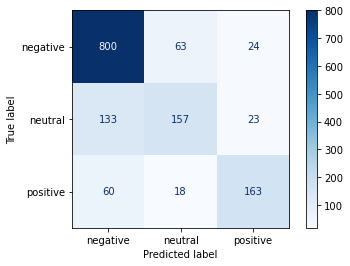

0.7690068772980091
0.7772380291464261
TruePositive: 163
FalsePositive: 47
FalseNegative: 78
TrueNegative: 1153


              precision    recall  f1-score   support

          -1      0.806     0.902     0.851       887
           0      0.660     0.502     0.570       313
           1      0.776     0.676     0.723       241

    accuracy                          0.777      1441
   macro avg      0.747     0.693     0.715      1441
weighted avg      0.769     0.777     0.769      1441

Model [bayes with bernoulliNB] at [300] features ->



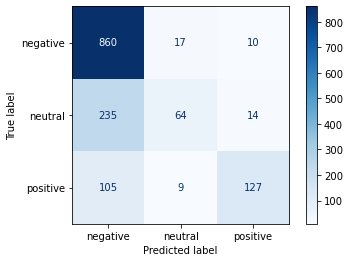

0.7362640356346438
0.7293546148507981
TruePositive: 127
FalsePositive: 24
FalseNegative: 114
TrueNegative: 1176


              precision    recall  f1-score   support

          -1      0.717     0.970     0.824       887
           0      0.711     0.204     0.318       313
           1      0.841     0.527     0.648       241

    accuracy                          0.729      1441
   macro avg      0.756     0.567     0.597      1441
weighted avg      0.736     0.729     0.685      1441

Model [bayes with multinomialNB] at [300] features ->



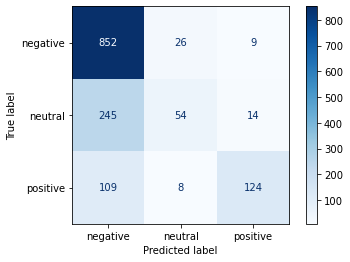

0.7092279769225417
0.7147814018043026
TruePositive: 124
FalsePositive: 23
FalseNegative: 117
TrueNegative: 1177


              precision    recall  f1-score   support

          -1      0.706     0.961     0.814       887
           0      0.614     0.173     0.269       313
           1      0.844     0.515     0.639       241

    accuracy                          0.715      1441
   macro avg      0.721     0.549     0.574      1441
weighted avg      0.709     0.715     0.667      1441



In [415]:
# encoding label using LabelEncoder()
from sklearn.preprocessing import LabelEncoder

MIN_FEATURE = 50 # inclusive
SELECTED_FEATURE = 300
MAX_FEATURE = 2050 # exclusive
FEATURE_INTERVAL = 50
SELECTED_CLASS_POSITION = 0

training_methods = []

# metrics 
metrics = {"performance": [], "accuracy": [], "balanced_accuracy": [], "precision": [], "recall": [], "f1": []}

# create our SVM classifier with the class LinearSVC
from sklearn.svm import LinearSVC
training_methods.append((LinearSVC(), "linear svc", copy.deepcopy(metrics)))

# create our Bayes classifier with the BernoulliNB
from sklearn.naive_bayes import BernoulliNB
training_methods.append((BernoulliNB(binarize=None), "bayes with bernoulliNB", copy.deepcopy(metrics)))

# create our Bayes classifier with the MultinomialNB
from sklearn.naive_bayes import MultinomialNB
training_methods.append((MultinomialNB(), "bayes with multinomialNB", copy.deepcopy(metrics)))

for n_features in range(MIN_FEATURE, MAX_FEATURE, FEATURE_INTERVAL):
    tfidf_vect = TfidfVectorizer(max_features=n_features)

    _x_train = tfidf_vect.fit_transform(x_train)
    _x_test = tfidf_vect.transform(x_test)

    for tm, name, metrics in training_methods:
        tm.fit(_x_train, y_train)
        
        prediction = tm.predict(_x_test)
        
        #print(confusion_matrix(y_test, prediction).ravel())
        
        tnpn, tnpne, tnpp, tnepn, tnepne, tnepp, tppn, tppne, tppp = [int(x) for x in confusion_matrix(y_test, prediction, labels=[-1,0,1]).ravel()]
        tp = tppp
        fp = tnpp + tnepp
        fn = tppne + tppn
        tn = tnepne + tnpn + tnepn + tnpne
        
        _performance_score = tm.score(_x_test, y_test)
        _accuracy_score = accuracy_score(y_test, prediction)
        _balanced_accuracy_score = balanced_accuracy_score(y_test, prediction)
        _precision_score = precision_score(y_test, prediction, average='weighted') 
        _recall_score = recall_score(y_test, prediction, average='weighted')
        _f1_score = f1_score(y_test, prediction, average='weighted')
        
        
        #The 3-class classification Confusion Matrix using three models.
        if n_features == SELECTED_FEATURE:
            print("Model [%s] at [%d] features ->\n" % (name, n_features))
            plot_confusion_matrix(tm, _x_test, y_test, display_labels=['negative', 'neutral', 'positive'], cmap=plt.cm.Blues)  
            plt.show()
            print(_precision_score)
            print(_recall_score)
            print("TruePositive: %d" % tp)
            print("FalsePositive: %d" % fp)
            print("FalseNegative: %d" % fn)
            print("TrueNegative: %d\n\n" % tn)
            print(classification_report(y_test, prediction, digits=3))
        
        metrics["performance"].append((n_features, _performance_score))
        metrics["accuracy"].append((n_features, _accuracy_score))
        metrics["balanced_accuracy"].append((n_features, _balanced_accuracy_score))
        metrics["precision"].append((n_features, _precision_score))
        metrics["recall"].append((n_features, _recall_score))
        metrics["f1"].append((n_features, _f1_score))

In [406]:
confusion_matrix(y_test, prediction, labels=[-1,0,1]).ravel()
# true vs predict,
# -1 vs -1; -1 vs 0; -1 vs 1; 0 vs -1, 0 vs 0; 0 vs 1; 1 vs -1; 1 vs 0; 1 vs 1 

array([868,  16,   3, 216,  83,  14, 109,  11, 121])

In [407]:
# draw the diagram
nfeatures_performance = []
nfeatures_accuracy = []
nfeatures_balanced_accuracy = []
nfeatures_precision = []
nfeatures_recall = []
nfeatures_f1 = []
for tm, name, metrics in training_methods:
    nfeatures_performance.append((name, pd.DataFrame(metrics['performance'], columns=['n_features', 'performance_score'])))
    nfeatures_accuracy.append((name, pd.DataFrame(metrics['accuracy'], columns=['n_features', 'accuracy_score'])))
    nfeatures_balanced_accuracy.append((name, pd.DataFrame(metrics['balanced_accuracy'], columns=['n_features', 'balanced_accuracy_score'])))
    nfeatures_precision.append((name, pd.DataFrame(metrics['precision'], columns=['n_features', 'precision_score'])))
    nfeatures_recall.append((name, pd.DataFrame(metrics['recall'], columns=['n_features', 'recall_score'])))
    nfeatures_f1.append((name, pd.DataFrame(metrics['f1'], columns=['n_features', 'f1_score'])))

=== Performance Score ===

Model Name [linear svc] has max performance score [0.798057] at [700] # of features
Model Name [bayes with bernoulliNB] has max performance score [0.743234] at [550] # of features
Model Name [bayes with multinomialNB] has max performance score [0.745316] at [1800] # of features


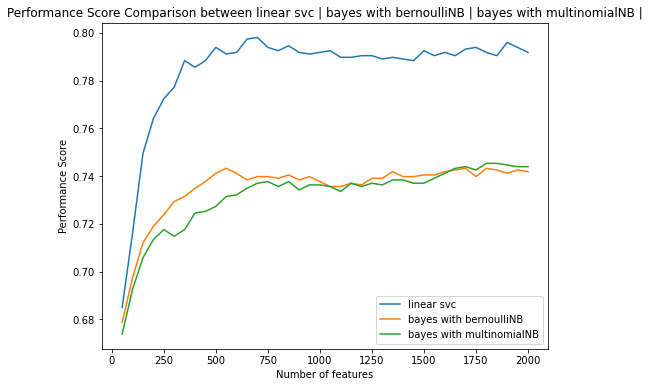

In [408]:
# performance diagram
plt.figure(figsize=(8,6))

title = "Performance Score Comparison between"

for name, df in nfeatures_performance:
    plt.plot(df.n_features, df.performance_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Performance Score")
plt.legend()

print("=== Performance Score ===\n")
for metrics in nfeatures_performance:
    max_performance_score_feature = 0
    max_performance_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _performance_score = metrics[1].loc[feature_index].performance_score
        # print("[%d] features -> [%f] performance score" % (_nfeatures, _performance_score))
        if _performance_score > max_performance_score:
            max_performance_score = _performance_score
            max_performance_score_feature = _nfeatures
    
    print("Model Name [%s] has max performance score [%f] at [%d] # of features" % (metrics[0], max_performance_score, max_performance_score_feature))

=== Accuracy Score ===

Model Name [linear svc] has max accuracy score [0.798057] at [700] # of features
Model Name [bayes with bernoulliNB] has max accuracy score [0.743234] at [550] # of features
Model Name [bayes with multinomialNB] has max accuracy score [0.745316] at [1800] # of features


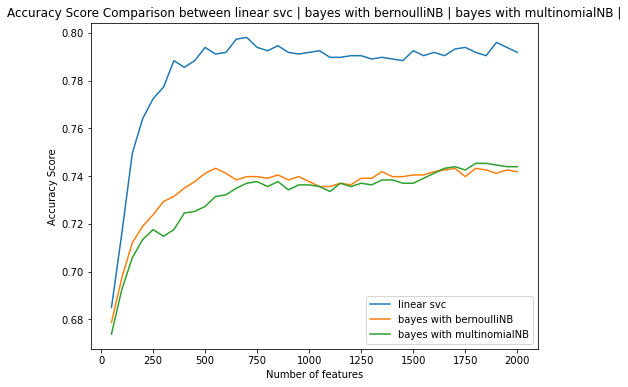

In [409]:
# accuracy diagram
plt.figure(figsize=(8,6))

title = "Accuracy Score Comparison between"

for name, df in nfeatures_accuracy:
    plt.plot(df.n_features, df.accuracy_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Accuracy Score")
plt.legend()
plt.savefig("image/airline-accuracy-%d-with-neu.png" % MAX_FEATURE)

print("=== Accuracy Score ===\n")
for metrics in nfeatures_accuracy:
    max_accuracy_score_feature = 0
    max_accuracy_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _accuracy_score = metrics[1].loc[feature_index].accuracy_score
        # print("[%d] features -> [%f] accuracy score" % (_nfeatures, _accuracy_score))
        if _accuracy_score > max_accuracy_score:
            max_accuracy_score = _accuracy_score
            max_accuracy_score_feature = _nfeatures
    
    print("Model Name [%s] has max accuracy score [%f] at [%d] # of features" % (metrics[0], max_accuracy_score, max_accuracy_score_feature))

=== Balanced Accuracy Score ===

Model Name [linear svc] has max balanced accuracy score [0.731320] at [1900] # of features
Model Name [bayes with bernoulliNB] has max balanced accuracy score [0.589839] at [550] # of features
Model Name [bayes with multinomialNB] has max balanced accuracy score [0.586406] at [1800] # of features


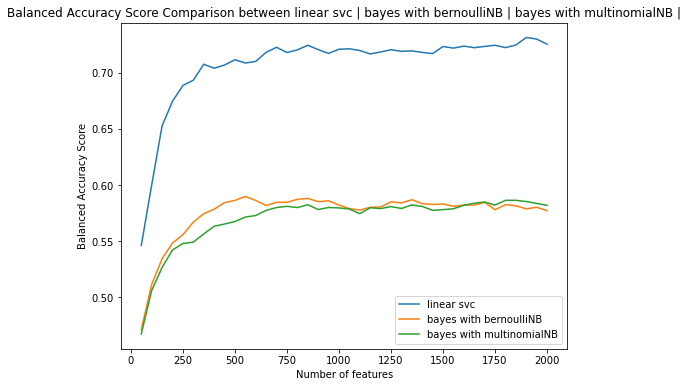

In [410]:
# accuracy diagram
plt.figure(figsize=(8,6))

title = "Balanced Accuracy Score Comparison between"

for name, df in nfeatures_balanced_accuracy:
    plt.plot(df.n_features, df.balanced_accuracy_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Balanced Accuracy Score")
plt.legend()
plt.savefig("image/airline-balanced-accuracy-%d-with-neu.png" % MAX_FEATURE)

print("=== Balanced Accuracy Score ===\n")
for metrics in nfeatures_balanced_accuracy:
    max_balanced_accuracy_score_feature = 0
    max_balanced_accuracy_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _balanced_accuracy_score = metrics[1].loc[feature_index].balanced_accuracy_score
        # print("[%d] features -> [%f] accuracy score" % (_nfeatures, _accuracy_score))
        if _balanced_accuracy_score > max_balanced_accuracy_score:
            max_balanced_accuracy_score = _balanced_accuracy_score
            max_balanced_accuracy_score_feature = _nfeatures
    
    print("Model Name [%s] has max balanced accuracy score [%f] at [%d] # of features" % (metrics[0], max_balanced_accuracy_score, max_balanced_accuracy_score_feature))

=== Precision Score ===

Model Name [linear svc] has max Precision score [0.791025] at [700] # of features
Model Name [bayes with bernoulliNB] has max Precision score [0.756956] at [1650] # of features
Model Name [bayes with multinomialNB] has max Precision score [0.759784] at [1800] # of features


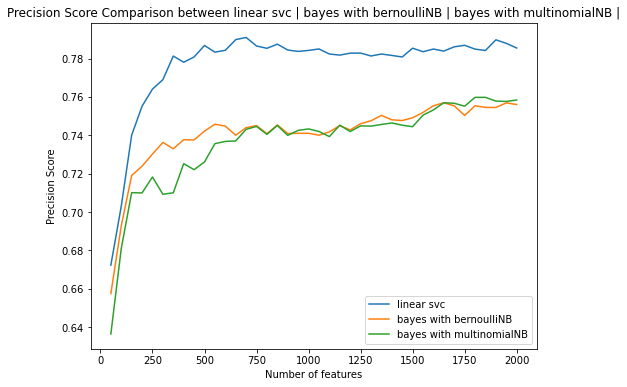

In [411]:
# precision diagram
plt.figure(figsize=(8,6))

title = "Precision Score Comparison between"

for name, df in nfeatures_precision:
    plt.plot(df.n_features, df.precision_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Precision Score")
plt.legend()
plt.savefig("image/airline-precision-%d-with-neu.png" % MAX_FEATURE)

print("=== Precision Score ===\n")
for metrics in nfeatures_precision:
    max_precision_score_feature = 0
    max_precision_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _precision_score = metrics[1].loc[feature_index].precision_score
        # print("[%d] features -> [%f] Precision score" % (_nfeatures, _precision_score))
        if _precision_score > max_precision_score:
            max_precision_score = _precision_score
            max_precision_score_feature = _nfeatures
    
    print("Model Name [%s] has max Precision score [%f] at [%d] # of features" % (metrics[0], max_precision_score, max_precision_score_feature))

=== Recall Score ===

Model Name [linear svc] has max Recall score [0.798057] at [700] # of features
Model Name [bayes with bernoulliNB] has max Recall score [0.743234] at [550] # of features
Model Name [bayes with multinomialNB] has max Recall score [0.745316] at [1800] # of features


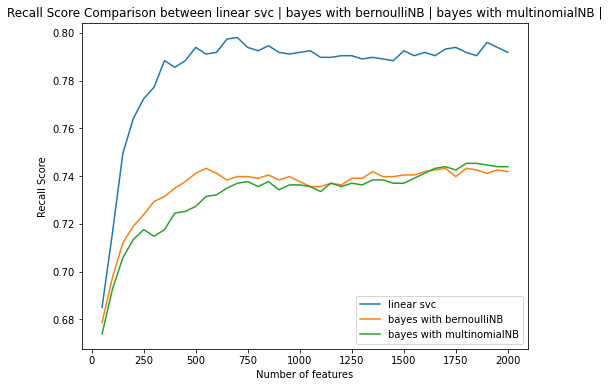

In [412]:
# recall diagram
plt.figure(figsize=(8,6))

title = "Recall Score Comparison between"

for name, df in nfeatures_recall:
    plt.plot(df.n_features, df.recall_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Recall Score")
plt.legend()
plt.savefig("image/airline-recall-%d-with-neu.png" % MAX_FEATURE)

print("=== Recall Score ===\n")
for metrics in nfeatures_recall:
    max_recall_score_feature = 0
    max_recall_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _recall_score = metrics[1].loc[feature_index].recall_score
        # print("[%d] features -> [%f] Recall score" % (_nfeatures, _recall_score))
        if _recall_score > max_recall_score:
            max_recall_score = _recall_score
            max_recall_score_feature = _nfeatures
    
    print("Model Name [%s] has max Recall score [%f] at [%d] # of features" % (metrics[0], max_recall_score, max_recall_score_feature))

=== F1 Score ===

Model Name [linear svc] has max F1 score [0.791598] at [1900] # of features
Model Name [bayes with bernoulliNB] has max F1 score [0.707589] at [1350] # of features
Model Name [bayes with multinomialNB] has max F1 score [0.708189] at [1800] # of features


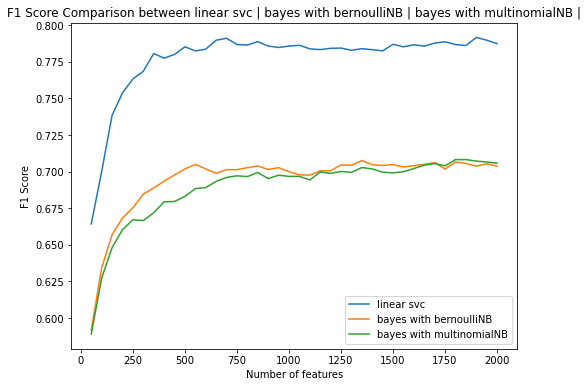

In [413]:
# f1 diagram
plt.figure(figsize=(8,6))

title = "F1 Score Comparison between"

for name, df in nfeatures_f1:
    plt.plot(df.n_features, df.f1_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("F1 Score")
plt.legend()
plt.savefig("image/airline-f1-%d-with-neu.png" % MAX_FEATURE)

print("=== F1 Score ===\n")
for metrics in nfeatures_f1:
    max_f1_score_feature = 0
    max_f1_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _f1_score = metrics[1].loc[feature_index].f1_score
        # print("[%d] features -> [%f] F1 score" % (_nfeatures, _f1_score))
        if _f1_score > max_f1_score:
            max_f1_score = _f1_score
            max_f1_score_feature = _nfeatures
    
    print("Model Name [%s] has max F1 score [%f] at [%d] # of features" % (metrics[0], max_f1_score, max_f1_score_feature))

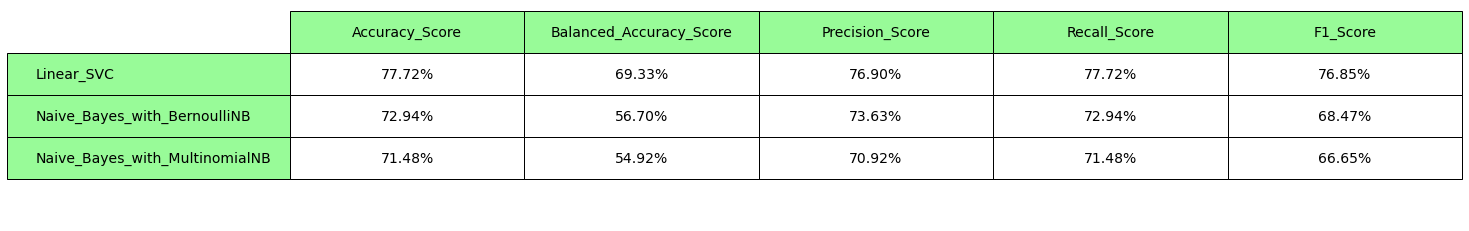

In [414]:
# precision, recall, f1, accuracy for all methods
# select # of features
loc_feature_index = SELECTED_FEATURE/FEATURE_INTERVAL - 1

lsvc_accuracy_score = nfeatures_accuracy[0][1].loc[loc_feature_index].accuracy_score
lsvc_balanced_accuracy_score = nfeatures_balanced_accuracy[0][1].loc[loc_feature_index].balanced_accuracy_score
lsvc_precision_score = nfeatures_precision[0][1].loc[loc_feature_index].precision_score
lsvc_recall_score = nfeatures_recall[0][1].loc[loc_feature_index].recall_score
lsvc_f1_score = nfeatures_f1[0][1].loc[loc_feature_index].f1_score

bcbn_accuracy_score = nfeatures_accuracy[1][1].loc[loc_feature_index].accuracy_score
bcbn_balanced_accuracy_score = nfeatures_balanced_accuracy[1][1].loc[loc_feature_index].balanced_accuracy_score
bcbn_precision_score = nfeatures_precision[1][1].loc[loc_feature_index].precision_score
bcbn_recall_score = nfeatures_recall[1][1].loc[loc_feature_index].recall_score
bcbn_f1_score = nfeatures_f1[1][1].loc[loc_feature_index].f1_score

bcmn_accuracy_score = nfeatures_accuracy[2][1].loc[loc_feature_index].accuracy_score
bcmn_balanced_accuracy_score = nfeatures_balanced_accuracy[2][1].loc[loc_feature_index].balanced_accuracy_score
bcmn_precision_score = nfeatures_precision[2][1].loc[loc_feature_index].precision_score
bcmn_recall_score = nfeatures_recall[2][1].loc[loc_feature_index].recall_score
bcmn_f1_score = nfeatures_f1[2][1].loc[loc_feature_index].f1_score

def to_percentage(list_val):
    return [str("%.2f" % (e*100)) + '%' for e in list_val]

val1 = ["Accuracy_Score", "Balanced_Accuracy_Score", "Precision_Score", "Recall_Score", "F1_Score",] 
val2 = ["Linear_SVC", "Naive_Bayes_with_BernoulliNB", "Naive_Bayes_with_MultinomialNB"] 
val3 = [[lsvc_accuracy_score, lsvc_balanced_accuracy_score, lsvc_precision_score, lsvc_recall_score, lsvc_f1_score],
        [bcbn_accuracy_score, bcbn_balanced_accuracy_score, bcbn_precision_score, bcbn_recall_score, bcbn_f1_score],
        [bcmn_accuracy_score, bcmn_balanced_accuracy_score, bcmn_precision_score, bcmn_recall_score, bcmn_f1_score]]
val3 = list(map(lambda a: to_percentage(a), val3))
  
fig, ax = plt.subplots() 
ax.set_axis_off() 
table = ax.table( 
    cellText = val3,  
    rowLabels = val2,  
    colLabels = val1, 
    rowColours =["palegreen"] * 10,  
    colColours =["palegreen"] * 10, 
    cellLoc ='center',  
    loc ='upper left')  


# table = ax.table(cellText=table_data, loc='center')
table.set_fontsize(14)
table.scale(3.5,3.5)
# ax.axis('off')

plt.show()